In [1]:
import pandas as pd
import numpy as np
import copy
import re
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors

def ug_per_ml_to_nM(solubility_ug_per_ml, smiles):
    molar_mass = Descriptors.ExactMolWt(Chem.MolFromSmiles(smiles))
    return solubility_ug_per_ml * 10**6 / molar_mass

def nM_to_log(value_nM):
    if value_nM==0.0:
        return np.NaN
    return -np.log10(value_nM * (10**-9))


def grep_pH(string):
    match = re.search('.+ph\s*(\d\.*\d*)', string.lower())
    if match is not None:
        return float(match[1])
    match = re.search('.+ph\s*of\s*(\d\.*\d*)', string.lower())
    if match is not None:
        return float(match[1])
    match = re.search('.+ph\s*\=\s*(\d\.*\d*)', string.lower())
    if match is not None:
        return float(match[1])
    match = re.search('.+ph\s*\-\s*(\d\.*\d*)', string.lower())
    if match is not None:
        return float(match[1])
    match = re.search('.+(\d\.*\d*)\s*ph', string.lower())
    if match is not None:
        return float(match[1])
    return np.NaN

def grep_solvent(string):
    solvent = np.NaN
    match = re.search('.*aqueous', string.lower())
    if match is not None:
        solvent = "water"
        return solvent        
    match = re.search('.*water', string.lower())
    if match is not None:
        solvent = "water"
        return solvent        
    match = re.search('.*h2o', string.lower())
    if match is not None:
        solvent = "water"
        return solvent                
    match = re.search('.*phosphate', string.lower())
    if match is not None:
        solvent = "pbs"
        return solvent        
    match = re.search('.*pbs', string.lower())
    if match is not None:
        solvent = "pbs"
        return solvent        
    match = re.search('.*dmso', string.lower())
    if match is not None:
        solvent = "dmso"
        return solvent
    match = re.search('.*tris', string.lower())
    if match is not None:
        solvent = "tris"
        return solvent
    return solvent

%matplotlib inline

In [2]:
data = pd.read_csv('deliverables/chembl_extract.csv', low_memory = False)

In [3]:
data = data.loc[data['assay_type'].isin(['P'])]

### solubility

In [4]:
solubility = copy.deepcopy(data.loc[((data['standard_type'] == 'Solubility') & 
                                    ((data['standard_units'] == 'ug.mL-1') | 
                                     (data['standard_units'] == 'nM'))) |
                                    (data['standard_type'] == 'Log S') |
                                    (data['standard_type'] == '-log(solubility)')])

In [5]:
pH = []
for string in solubility['assay_description']:
    pH.append(grep_pH(string))
solubility['pH'] = pH
solvent = list()
for string in solubility['assay_description']:
    solvent.append(grep_solvent(string))
solubility['solvent'] = solvent
solubility.dropna(subset=['pH', 'solvent'], inplace=True)
solubility.reset_index(inplace=True)
solubility['pH_solvent'] = [str(x)+'_'+y for x,y in zip(solubility['pH'], solubility['solvent'])]

In [6]:
logS = list()
for i in solubility.index:
    if solubility['standard_type'][i] == 'Solubility':
        if solubility['standard_units'][i]=='ug.mL-1':
            logS.append(nM_to_log(ug_per_ml_to_nM(solubility['standard_value'][i], solubility['canonical_smiles'][i])))
        elif solubility['standard_units'][i]=='nM':
            logS.append(nM_to_log(solubility['standard_value'][i]))
    elif (solubility['standard_type'][i]=='Log S') or (solubility['standard_type'][i]=='-log(solubility)'):
        logS.append(solubility['standard_value'][i])
solubility['logS']=logS
solubility.dropna(subset=['logS'], inplace=True)
solubility.reset_index(inplace=True)

In [7]:
print(min(solubility['logS']))
print(max(solubility['logS']))

-8.7
11.47597560832878


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x139ddf7f0>]],
      dtype=object)

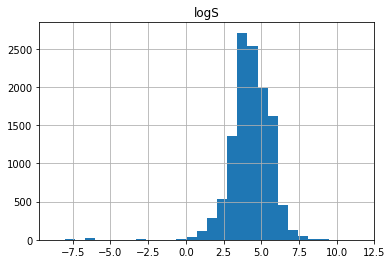

In [8]:
solubility.hist(['logS'], bins=30)

In [9]:
solubility.groupby(['pH_solvent']).count().sort_values('canonical_smiles', ascending = False)['canonical_smiles'][:19]

pH_solvent
7.4_water    3451
7.4_pbs      3063
7.0_water     858
6.5_pbs       657
6.8_water     647
6.5_water     592
2.0_water     374
7.0_pbs       231
4.0_water     195
6.8_pbs       193
7.2_water     139
1.0_water     122
6.8_dmso      101
1.2_water      96
7.2_pbs        96
2.0_pbs        84
5.0_water      84
7.4_dmso       56
7.5_water      50
Name: canonical_smiles, dtype: int64

In [10]:
print(len(solubility))

11900


### logd

In [11]:
logd = copy.deepcopy(data.loc[(data['standard_type'] == 'LogD') | 
                            (data['standard_type'] == 'LogD6.5') | 
                            (data['standard_type'] == 'LogD7.4') | 
                            (data['standard_type'] == 'LogD5.0')])

In [12]:
print(min(logd['standard_value']))
print(max(logd['standard_value']))

-14.0
4872.0


In [13]:
pH = []
for string in logd['assay_description']:
    pH.append(grep_pH(string))
logd['pH'] = pH
for i in logd.index:
    if data['standard_type'][i]=='LogD6.5':
        logd.at[i, 'pH']=6.5
    if data['standard_type'][i]=='LogD7.4':
        logd.at[i, 'pH']=7.4
    if data['standard_type'][i]=='LogD5.0':
        logd.at[i, 'pH']=5.0
logd.dropna(subset=['pH'], inplace=True)
logd.reset_index(inplace=True)
logd = logd.loc[(logd['standard_value']<20) &(logd['standard_value']>-10)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13ba2eda0>]],
      dtype=object)

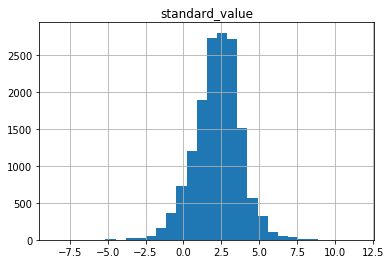

In [14]:
logd.hist(['standard_value'], bins=30)

In [15]:
logd.groupby(['pH']).count().sort_values('canonical_smiles', ascending = False)['canonical_smiles'][:10]

pH
7.4     13876
7.0       218
3.0       199
6.5       173
7.2       112
6.8       112
5.0        68
5.5        54
7.3        50
7.5        44
2.0        40
6.0        40
5.2        39
10.0       33
Name: canonical_smiles, dtype: int64

In [16]:
print(len(logd))

15315


### logp

In [17]:
logp =  copy.deepcopy(data.loc[data['standard_type'] == 'LogP'])

In [18]:
print(min(logp['standard_value']))
print(max(logp['standard_value']))

-741.0
27000.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13b77f4a8>]],
      dtype=object)

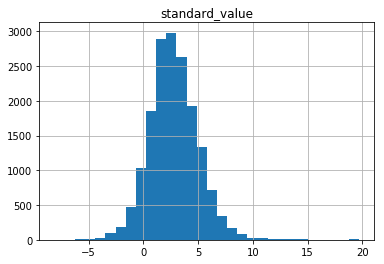

In [19]:
logp = logp.loc[(logp['standard_value']<20) & (logp['standard_value']>-10)]
logp.hist(['standard_value'], bins=30)

In [20]:
print(len(logp))

16853


In [21]:
solubility.to_csv('data/physicochemical_solubility.csv', index=False)

In [22]:
logd.to_csv('data/physicochemical_logd.csv', index=False)

In [23]:
logp.to_csv('data/physicochemical_logp.csv', index=False)